<a href="https://colab.research.google.com/github/audwls4545/metaverse/blob/main/aivill_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 모듈설치
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')
model.summary()

553467096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [5]:
# from keras.preprocessingimport image # 예전버전
import keras.utils as image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [6]:
# The local path to our target image
# img_path= '/content/creative_commons_elephant.jpg' #코랩에업로드한경우
img_path= '/content/drive/MyDrive/aivill/creative_commons_elephant.jpg' #구글드라이브에업로드한경우

In [7]:
# `img` is a PIL image of size 224x224
img= image.load_img(img_path, target_size=(224, 224))
# `x` is a float32 Numpyarray of shape (224, 224, 3)
x = image.img_to_array(img)
# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [8]:
preds= model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])
np.argmax(preds[0])

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.8220685), ('n01871265', 'tusker', 0.15688314), ('n02504013', 'Indian_elephant', 0.01920006)]


386

In [9]:
import keras
import tensorflow as tf
import tensorflow.keras.backend as K

In [10]:
african_elephant_output= model.output[:, 386] # 예측벡터의아프리카코끼리항목
last_conv_layer= model.get_layer('block5_conv3') # VGG16의마지막합성곱층인block5_conv3 층의특성맵


In [11]:
grad_model= keras.models.Model(
model.inputs, [last_conv_layer.output, model.output]
)

In [13]:
with tf.GradientTape() as tape:
    last_conv_layer_output, preds= grad_model(x)
    pred_index= tf.argmax(preds[0])
    class_channel= preds[:, pred_index]

In [14]:
# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel, last_conv_layer_output)
pooled_grads= K.mean(grads, axis=(0, 1, 2))
last_conv_layer_output= last_conv_layer_output[0]
heatmap= last_conv_layer_output@ pooled_grads[..., tf.newaxis]
heatmap= tf.squeeze(heatmap)

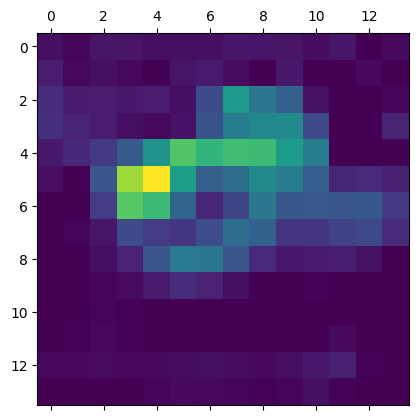

In [16]:
# 히트맵후처리하기
import matplotlib.pyplot as plt
heatmap= np.maximum(heatmap, 0)
heatmap/= np.max(heatmap)
plt.matshow(heatmap)

In [18]:
import cv2
from IPython.display import Image, display

In [19]:
img= cv2.imread(img_path) # cv2 모듈을사용하여원본이미지로드

In [20]:
heatmap= cv2.resize(heatmap, (img.shape[1], img.shape[0])) # heatmap을원본이미지크기에맞게변경

In [21]:
heatmap= np.uint8(255 * heatmap) # heatmap을RGB 포맷으로변환

In [22]:
heatmap= cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # 히트맵으로변환

In [23]:
superimposed_img= heatmap* 0.4 + img# 0.4는히트맵강도

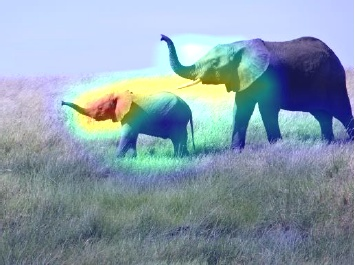

In [24]:
save_path= '/content/drive/MyDrive/aivill/creative_commons_elephant.jpg'
cv2.imwrite(save_path, superimposed_img) # 이미지저장한
display(Image(save_path))